# Problemas

Nesta prática iremos usar tudo que aprendemos durante o módulo.
Logo, **seu objetivo é determinar e implementar um modelo para cada problema.**

Lembre-se de definir:

1. o Dataloader, tratando a forma de ler as imagens de cada dataset, experimentando transformações diferentes (resize, crop, flips e etc.)
1. uma arquitetura (tentem usar tanto arquiteturas existentes como propor novas usando camadas de convolução, pooling, e densas),
1. uma função de custo
1. um algoritmo de otimização (agora, como os problemas são maiores, será possível notar mais claramente a diferença entre diferentes algoritmos).





In [ ]:
#%load_ext nbproxy
!pip install torchsummary

In [1]:
import time, os, sys, numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import PIL
from PIL import Image
from torch import optim
from torchsummary import summary

# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n = torch.cuda.device_count()
devices_ids= list(range(n))

cuda


In [2]:
# funções básicas

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    net.eval()
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)

# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss, num_epochs):
    print('training on', device)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)

            y_hat = net(X)
            if isinstance(y_hat, tuple):
                # If Inception model, handle auxiliary outputs
                y_hat, aux_output = y_hat
                aux_loss = loss(aux_output, y).sum()
                l = loss(y_hat, y).sum() + 0.4 * aux_loss  # Combine main and auxiliary loss
            else:
                l = loss(y_hat, y).sum()

            trainer.zero_grad()
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]

        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)

        train_loss = train_l_sum / len(train_iter)
        train_acc = train_acc_sum / n
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_loss, train_acc, test_loss, test_acc, time.time() - start))

    # Plotar as perdas (loss) e acurácias como subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot para perdas (loss)
    ax1.set_title("Training and Test Loss")
    ax1.plot(train_losses, label="Train")
    ax1.plot(test_losses, label="Test")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Subplot para acurácias
    ax2.set_title("Training and Test Accuracy")
    ax2.plot(train_accuracies, label="Train")
    ax2.plot(test_accuracies, label="Test")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()


## Problema 1 - Exemplo

Neste problema, classificaremos imagens histólogica do dataset [*Colorectal Histology*](https://www.kaggle.com/kmader/colorectal-histology-mnist).
Neste caso, vamos receber imagens com tamanho de $150\times 150$ pixels e classificá-las entre 8 classes:

1. tumor
1. stroma
1. complex
1. lympho
1. debris
1. mucosa
1. adipose
1. empty

In [ ]:
!wget https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
!unzip -q Kather_texture_2016_image_tiles_5000.zip

--2024-06-28 12:53:09--  https://www.dropbox.com/s/k0f6vxyhcr6gh1r/Kather_texture_2016_image_tiles_5000.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/eyds9w2eqfkq7rx86z4oj/Kather_texture_2016_image_tiles_5000.zip?rlkey=w9zrj0hx7dflh7913i4ds0fi7 [following]
--2024-06-28 12:53:10--  https://www.dropbox.com/scl/fi/eyds9w2eqfkq7rx86z4oj/Kather_texture_2016_image_tiles_5000.zip?rlkey=w9zrj0hx7dflh7913i4ds0fi7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd42f00302baba292f26148c87f.dl.dropboxusercontent.com/cd/0/inline/CVuTL4TH0evdy0XQzXfGr9dpBh4JY2_5hv7FRM8_CW5uyZh-gDKhyrlgVMtJA3e2C2uunG5zqF6STFMytOGBvkFxoLe28gvtZtmZBQmUdPrabFMvAlTHPzuNpoxlud1IreI/file# [following]
--2024-06-28 12:53:11--  https://ucd

### Visualizando o Dataset

Number of images in class 06_MUCOSA: 625
Number of images in class 08_EMPTY: 625
Number of images in class 02_STROMA: 625
Number of images in class 01_TUMOR: 625
Number of images in class 03_COMPLEX: 625
Number of images in class 07_ADIPOSE: 625
Number of images in class 04_LYMPHO: 625
Number of images in class 05_DEBRIS: 625
Total number of images: 5000


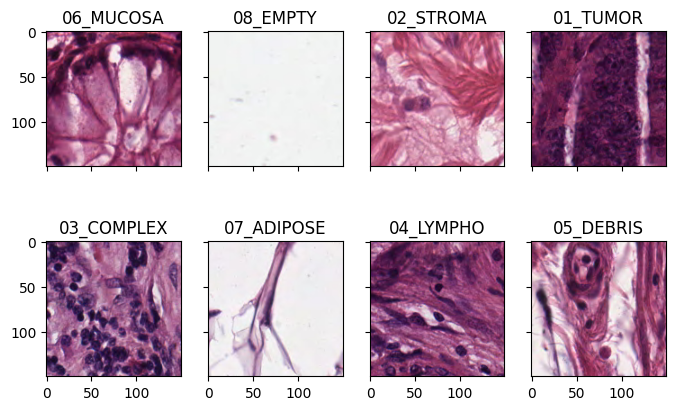

In [ ]:
import random

rows = 2
columns = 4

fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(8, 5))

path = 'Kather_texture_2016_image_tiles_5000'
total_num_images = 0
for idx, folder in enumerate(os.listdir(path)):
  folder_path = os.path.join(path, folder)
  num_images = len(os.listdir(folder_path))
  total_num_images += num_images
  print(f"Number of images in class {folder}: {num_images}")

  img_name = random.sample(os.listdir(folder_path), 1)[0]
  img = np.asarray(Image.open(os.path.join(folder_path, img_name)))

  ax = axs[idx//columns][idx%columns]
  ax.set_title(folder)
  ax.imshow(img)

print(f"Total number of images: {total_num_images}")

### Dataloader

In [ ]:
class HistologyDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'tumor': 0, 'stroma': 1, 'complex': 2, 'lympho': 3,
                   'debris': 4, 'mucosa': 5, 'adipose': 6, 'empty': 7} # dicionário para definir o label de cada classe
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # Leitura das imagens do dataset
        # para este caso, o dataset divide em pastas as imagens de cada classe correspondente
        # portanto, vamos percorrer essas pastas, adicionando as primeiras 500 imagens para o conjunto de treino
        # o restante das imagens (a partir da 500) são adicionadas na validação
        # o label é definido de acordo com o nome da pasta pelo dicionário self.le definido acima
        # por exemplo: a pasta 01_TUMOR vai ser correspondente ao self.le['tumor'], que é igual a 0
        img_list, labels = [], []
        if self.train is True:
          for folder in os.listdir(self.root):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num < 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])
        else:
          for folder in os.listdir(os.path.join(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
                if num >= 500:
                  img_list.append(os.path.join(self.root, folder, img_name))
                  labels.append(self.le[folder.split('_')[1].lower()])

        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 #if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter

# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=None)

### Implementação das Redes

#### CNN criada do zero

training on cuda
epoch 1, train loss 2.0726, train acc 0.139, test loss 2.0466, test acc 0.311, time 17.8 sec
epoch 2, train loss 2.0034, train acc 0.231, test loss 1.9603, test acc 0.411, time 16.2 sec
epoch 3, train loss 1.7593, train acc 0.356, test loss 1.6334, test acc 0.403, time 16.7 sec
epoch 4, train loss 1.3497, train acc 0.494, test loss 1.2901, test acc 0.533, time 16.2 sec
epoch 5, train loss 1.1339, train acc 0.567, test loss 1.3053, test acc 0.504, time 16.6 sec
epoch 6, train loss 0.9908, train acc 0.620, test loss 1.4950, test acc 0.485, time 19.6 sec
epoch 7, train loss 0.9195, train acc 0.656, test loss 1.2416, test acc 0.517, time 16.3 sec
epoch 8, train loss 0.8101, train acc 0.699, test loss 0.9517, test acc 0.639, time 16.6 sec
epoch 9, train loss 0.7344, train acc 0.725, test loss 1.0592, test acc 0.598, time 16.7 sec
epoch 10, train loss 0.6987, train acc 0.742, test loss 1.2050, test acc 0.575, time 17.0 sec
epoch 11, train loss 0.7147, train acc 0.738, test l

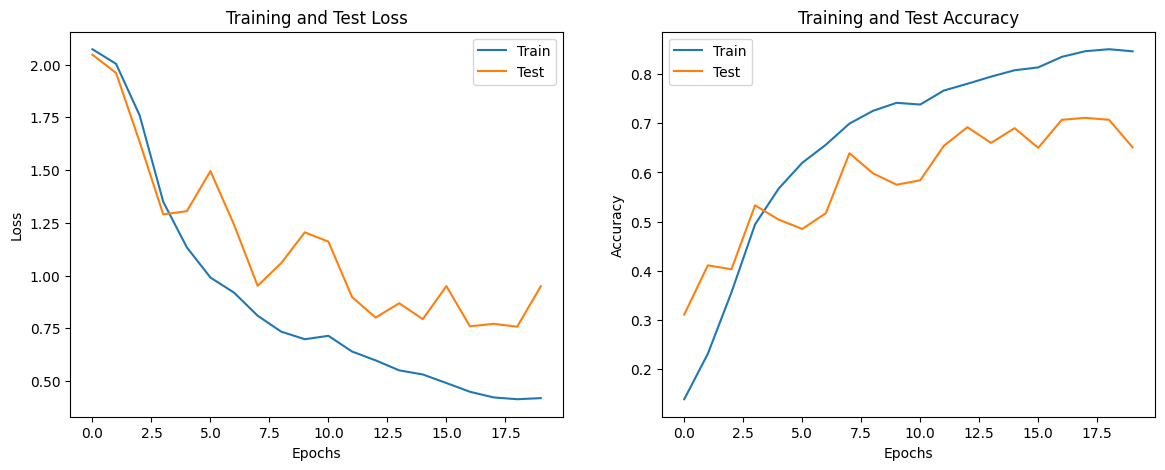

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(MyCNNModel, self).__init__()
        # Primeira camada -> Input=3x150x150 | Output=64x75x75
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Segunda camada -> Input=64x75x75 | Output=128x37x37
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.3)

        # Terceira camada -> Input=128x37x37 | Output=256x18x18
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.3)

        # Fully connected -> Input=256x18x18
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(256 * 18 * 18, 512)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        # Camada de saída
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.drop4(x)

        x = self.fc2(x)
        return x

num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = MyCNNModel(num_classes=8)
model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# carregamento do dado
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=None)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Replicando a Alexnet

training on cuda
epoch 1, train loss 3.2109, train acc 0.261, test loss 1.5799, test acc 0.308, time 22.5 sec
epoch 2, train loss 1.5137, train acc 0.348, test loss 1.4401, test acc 0.382, time 21.8 sec
epoch 3, train loss 1.3784, train acc 0.416, test loss 1.3275, test acc 0.469, time 22.0 sec
epoch 4, train loss 1.1228, train acc 0.551, test loss 0.8917, test acc 0.628, time 21.3 sec
epoch 5, train loss 0.8766, train acc 0.652, test loss 0.8103, test acc 0.672, time 22.0 sec
epoch 6, train loss 0.7608, train acc 0.709, test loss 1.1347, test acc 0.551, time 21.9 sec
epoch 7, train loss 0.7371, train acc 0.718, test loss 0.8195, test acc 0.692, time 21.8 sec
epoch 8, train loss 0.6858, train acc 0.740, test loss 0.6217, test acc 0.781, time 21.9 sec
epoch 9, train loss 0.6824, train acc 0.739, test loss 0.5942, test acc 0.767, time 21.4 sec
epoch 10, train loss 0.6171, train acc 0.765, test loss 0.7403, test acc 0.711, time 22.3 sec
epoch 11, train loss 0.6236, train acc 0.775, test l

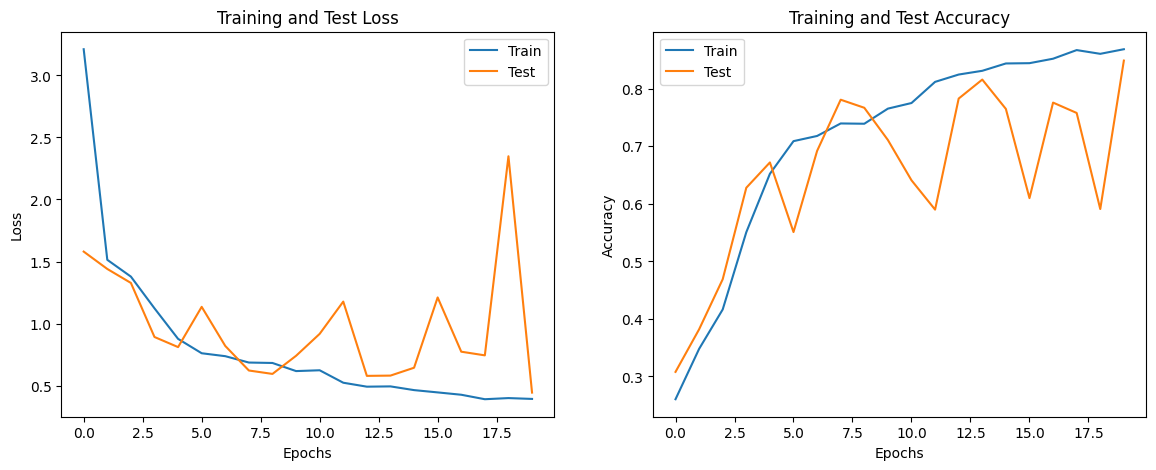

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, input_channels, classes=10, **kwargs):
        super(AlexNet, self).__init__(**kwargs)

        # Entrada -> 227 x 227 x 3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 27 x 27 x 96
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 13 x 13 x 256
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        ) # 13 x 13 x 384
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        ) # 13 x 13 x 384
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 6 x 6 x 256
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_epochs, lr, batch_size, wd_lambda = 20, 0.001, 100, 0.0001

model = AlexNet(input_channels=3, classes=8)
model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd_lambda)

# carregamento do dado
resize_size = 227
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=resize_size)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Usando a ResNet18 Pré Treinada

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


training on cuda
epoch 1, train loss 1.0355, train acc 0.682, test loss 0.4519, test acc 0.881, time 27.2 sec
epoch 2, train loss 0.3317, train acc 0.907, test loss 0.2736, test acc 0.905, time 27.3 sec
epoch 3, train loss 0.2330, train acc 0.927, test loss 0.2284, test acc 0.918, time 27.0 sec
epoch 4, train loss 0.1700, train acc 0.953, test loss 0.2115, test acc 0.927, time 27.8 sec
epoch 5, train loss 0.1315, train acc 0.963, test loss 0.1962, test acc 0.931, time 26.9 sec
epoch 6, train loss 0.1074, train acc 0.976, test loss 0.1908, test acc 0.935, time 27.9 sec
epoch 7, train loss 0.0863, train acc 0.980, test loss 0.1843, test acc 0.933, time 27.3 sec
epoch 8, train loss 0.0644, train acc 0.989, test loss 0.1808, test acc 0.941, time 27.7 sec
epoch 9, train loss 0.0491, train acc 0.993, test loss 0.1792, test acc 0.937, time 27.4 sec
epoch 10, train loss 0.0411, train acc 0.995, test loss 0.1806, test acc 0.937, time 27.1 sec
epoch 11, train loss 0.0321, train acc 0.997, test l

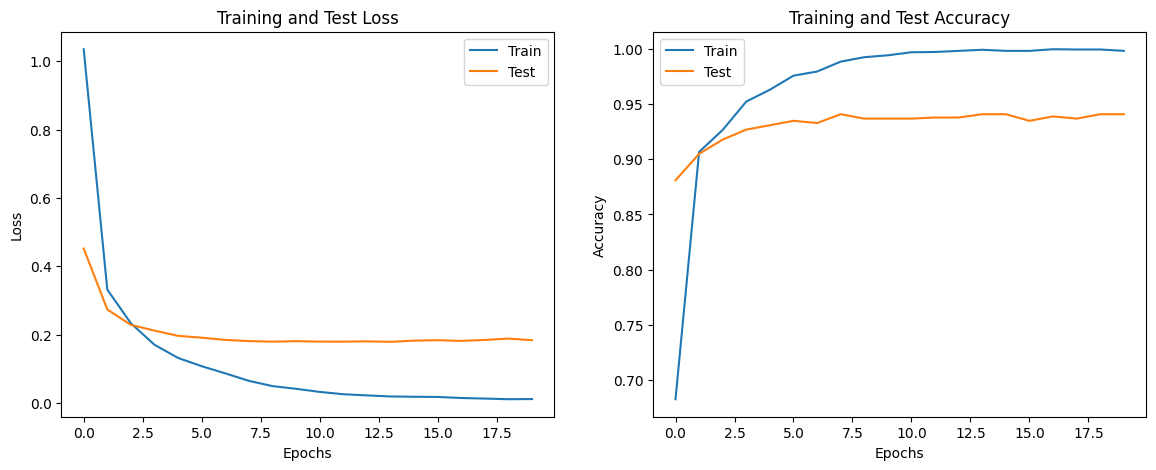

In [ ]:
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# carregamento do dado
resize_size = 224
train_iter, test_iter = load_data(HistologyDataset, 'Kather_texture_2016_image_tiles_5000', batch_size, resize=resize_size)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

### **Conclusões**

O primeiro dataset explorado foi o Color Rectal Histology, contendo imagens de 150x150 pixels. Três abordagens distintas foram utilizadas para modelar este dataset: uma CNN criada do zero, a AlexNet e a ResNet18 pré-treinada.


**CNN Criada do Zero**

A CNN desenvolvida do zero apresentou uma acurácia de treinamento de 0.846 e uma acurácia de teste de 0.651. Estes resultados sugerem que a rede neural conseguiu capturar parte da complexidade do dataset, mas houve um claro indício de overfitting, já que a diferença entre as acurácias de treinamento e de teste é significativa. O overfitting observado pode ser atribuído a uma falta de augmentations adequadas, que poderiam ter ajudado a generalizar melhor o modelo. Em resumo, a CNN do zero não conseguiu aprender de maneira eficaz a representar os dados complexos do dataset.

**AlexNet**

A AlexNet, por outro lado, alcançou uma acurácia de teste superior, atingindo 0.849, com uma acurácia de treino de 0.869. Apesar da melhora no desempenho em relação à CNN do zero, o treinamento da AlexNet foi marcado por instabilidades, evidenciadas por altas variações na loss e na acurácia de teste. Este comportamento instável pode ser explicado pelo uso do otimizador Adam, que, embora seja eficiente para muitos problemas, pode introduzir oscilações no treinamento devido à sua adaptação dinâmica das taxas de aprendizado. Portanto, a AlexNet apresentou um desempenho melhor, mas com uma trajetória de treinamento menos estável.

**ResNet18 Pré-treinada**

A ResNet18 pré-treinada apresentou os melhores resultados entre todas as abordagens. Ela conseguiu uma acurácia de treino de 0.999 e uma acurácia de teste de 0.941, demonstrando uma compreensão excelente dos dados e uma capacidade de predição robusta. A superioridade da ResNet18 pode ser atribuída ao fato de ser uma rede pré-treinada em milhões de outras imagens, o que lhe confere pesos e filtros bem ajustados. Com um dataset relativamente pequeno, de aproximadamente 5.000 imagens, o treinamento de uma rede do zero se torna desafiador. Assim, o fine-tuning de uma rede pré-treinada, como a ResNet18, mostrou-se como a abordagem mais eficaz.

## Problema 2

Neste problema, classificaremos imagens de sensoriamento remoto de plantações de café do dataset público [Brazilian Coffee Scenes](http://www.patreo.dcc.ufmg.br/2017/11/12/brazilian-coffee-scenes-dataset/).
Neste caso, , vamos receber imagens de $64\times 64$ pixels e classificá-las entre duas classes:

1. café, e
2. não café.

In [ ]:
# Baixando o dataset
!wget http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
!unzip -q brazilian_coffee_dataset.zip

--2024-06-28 13:15:33--  http://www.patreo.dcc.ufmg.br/wp-content/uploads/2017/11/brazilian_coffee_dataset.zip
Resolving www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)... 150.164.144.15
Connecting to www.patreo.dcc.ufmg.br (www.patreo.dcc.ufmg.br)|150.164.144.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4796290 (4.6M) [application/zip]
Saving to: ‘brazilian_coffee_dataset.zip’

brazilian_coffee_da 100%[===================>]   4.57M  3.32MB/s    in 1.4s    

2024-06-28 13:15:36 (3.32 MB/s) - ‘brazilian_coffee_dataset.zip’ saved [4796290/4796290]



### Visualizando os Dados

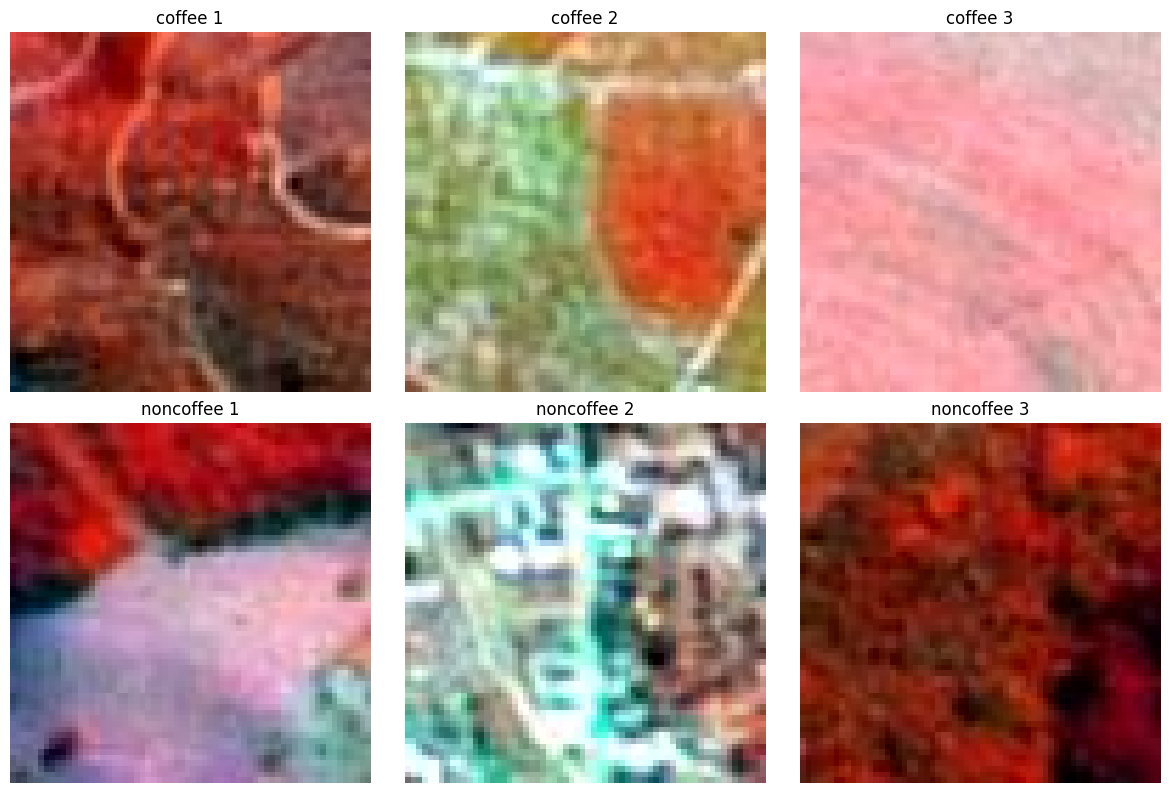

Number of images in class coffee: 1438
Number of images in class noncoffee: 1438
Total number of images: 2876


In [ ]:
rows, columns = 2, 3
classes = ['coffee', 'noncoffee']
base_dir = 'brazilian_coffee_scenes'
class_folders = [f'fold{i}' for i in range(1, 6)]
txt_files = [f'fold{i}.txt' for i in range(1, 6)]

fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(12, 8))

images = {cls: [] for cls in classes}
for folder, txt_file in zip(class_folders, txt_files):
    folder_path = os.path.join(base_dir, folder)
    txt_path = os.path.join(base_dir, txt_file)
    with open(txt_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split('.')
            label, img_name = parts[0], '.'.join(parts[1:])
            class_label = 'coffee' if label == 'coffee' else 'noncoffee'
            images[class_label].append(os.path.join(folder_path, f"{img_name}.jpg"))

for idx, cls in enumerate(classes):
    for jdx, img_path in enumerate(random.sample(images[cls], 3)):
        img = np.asarray(Image.open(img_path))
        axs[idx, jdx].imshow(img)
        axs[idx, jdx].set_title(f'{cls} {jdx+1}')
        axs[idx, jdx].axis('off')

plt.tight_layout()
plt.show()

for cls, img_list in images.items():
    print(f"Number of images in class {cls}: {len(img_list)}")

total_images = sum(len(img_list) for img_list in images.values())
print(f"Total number of images: {total_images}")

### DataLoader

In [ ]:
class CoffeeDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=True, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.load_images()
        self.transform = transform

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # para este dataset, existem 5 pastas (fold1, fold2, ..., fold5) com as imagens
        # e existem 5 arquivos txts (fold1.txt, fold2.txt, ..., fold5.txt) com o nome das imagens correspondentes
        # nos arquivos txts, cada linha representa uma imagem seguindo o formato {classe}.{nome da img}
        # sendo classe igual a coffee ou noncoffee (0 ou 1)
        # tratamos o nome das imagens de acordo com cada linha do arquivo (não esquecendo de adicionar o .jpg)
        # convertemos o label em 0 ou 1 dependendo da classe
        # Vamos utilizar o fold 1 como validação e o restante dos folds como treino
        img_list, labels = [], []
        if self.train is True:
          for i in range(1,5):
            data_file = open(os.path.join(root, 'fold' + str(i+1) + '.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold' + str(i+1), img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)
        else:
            data_file = open(os.path.join(root, 'fold1.txt'), "r")  # arquivo com nome das imagens
            data_list = [i.replace('\n', '') for i in data_file.readlines()]
            for row in data_list:
                img_name = '.'.join(row.split('.')[1:])
                img_list.append(os.path.join(root, 'fold1', img_name + '.jpg'))
                labels.append(0 if row.split('.')[0] == 'coffee' else 1)

        return img_list, labels

    def __getitem__(self, item):
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            cur_img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            cur_img = self.transform(Image.open(self.img_list[item]))
        cur_label = self.labels[item]
        return cur_img, cur_label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # neste caso, a sequência é um redimensionamento da imagem (caso a variável resize seja definida)
    # seguido de uma transformação para tensor
    # várias outras transformações estão disponíveis no Pytorch, como crops, flips, espelhamento e etc.
    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer += [torchvision.transforms.ToTensor()]
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste
    return train_iter, test_iter

# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=None)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Implementação das Redes

#### CNN criada do zero

training on cuda
epoch 1, train loss 0.6944, train acc 0.508, test loss 0.6847, test acc 0.538, time 2.2 sec
epoch 2, train loss 0.6844, train acc 0.554, test loss 0.6776, test acc 0.698, time 2.2 sec
epoch 3, train loss 0.6734, train acc 0.591, test loss 0.6603, test acc 0.593, time 2.2 sec
epoch 4, train loss 0.6556, train acc 0.621, test loss 0.6262, test acc 0.760, time 3.0 sec
epoch 5, train loss 0.6088, train acc 0.694, test loss 0.5748, test acc 0.767, time 2.2 sec
epoch 6, train loss 0.5610, train acc 0.734, test loss 0.5219, test acc 0.743, time 2.2 sec
epoch 7, train loss 0.5335, train acc 0.747, test loss 0.4973, test acc 0.770, time 2.2 sec
epoch 8, train loss 0.5157, train acc 0.755, test loss 0.4616, test acc 0.793, time 2.2 sec
epoch 9, train loss 0.4984, train acc 0.765, test loss 0.4725, test acc 0.788, time 2.9 sec
epoch 10, train loss 0.4841, train acc 0.769, test loss 0.4484, test acc 0.792, time 2.5 sec
epoch 11, train loss 0.4686, train acc 0.787, test loss 0.4301

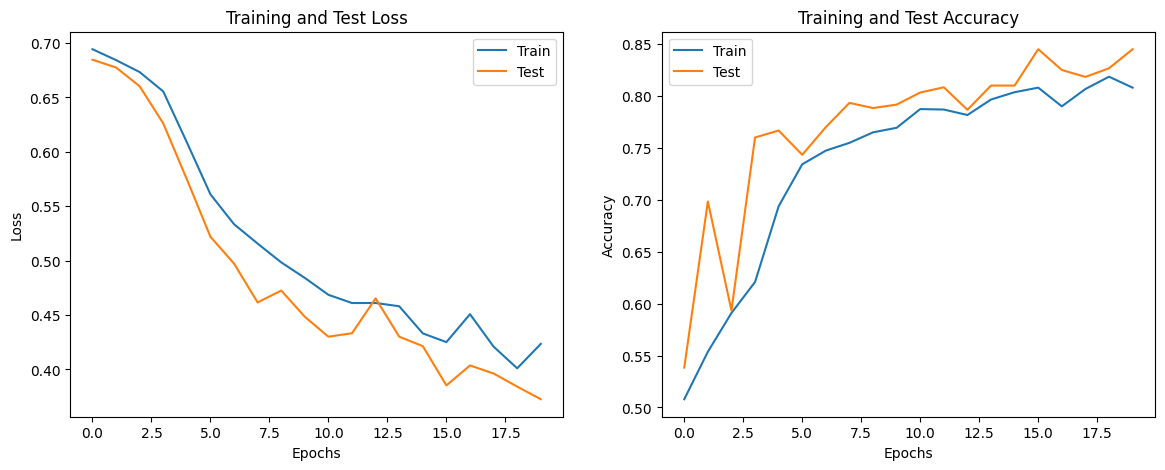

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MyCNNModel, self).__init__()
        # Primeira camada -> Input=3x64x64 | Output=64x32x32
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Segunda camada -> Input=64x32x32 | Output=128x16x16
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.3)

        # Terceira camada -> Input=128x16x16 | Output=256x8x8
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.3)

        # Fully connected -> Input=256x8x8
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        # Camada de saída
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.drop4(x)

        x = self.fc2(x)
        return x

num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = MyCNNModel(num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=None)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Replicando a AlexNet

training on cuda
epoch 1, train loss 4.7803, train acc 0.530, test loss 0.8865, test acc 0.510, time 7.7 sec
epoch 2, train loss 0.6269, train acc 0.658, test loss 0.5488, test acc 0.735, time 8.7 sec
epoch 3, train loss 0.5578, train acc 0.734, test loss 0.4992, test acc 0.778, time 8.3 sec
epoch 4, train loss 0.5045, train acc 0.771, test loss 0.4669, test acc 0.813, time 8.0 sec
epoch 5, train loss 0.4444, train acc 0.803, test loss 0.4210, test acc 0.828, time 8.6 sec
epoch 6, train loss 0.4246, train acc 0.821, test loss 0.3849, test acc 0.847, time 7.6 sec
epoch 7, train loss 0.3837, train acc 0.832, test loss 0.4203, test acc 0.798, time 8.6 sec
epoch 8, train loss 0.3647, train acc 0.848, test loss 0.4564, test acc 0.755, time 8.7 sec
epoch 9, train loss 0.3410, train acc 0.861, test loss 0.5024, test acc 0.785, time 7.5 sec
epoch 10, train loss 0.3525, train acc 0.852, test loss 0.2913, test acc 0.887, time 8.6 sec
epoch 11, train loss 0.3180, train acc 0.877, test loss 0.5625

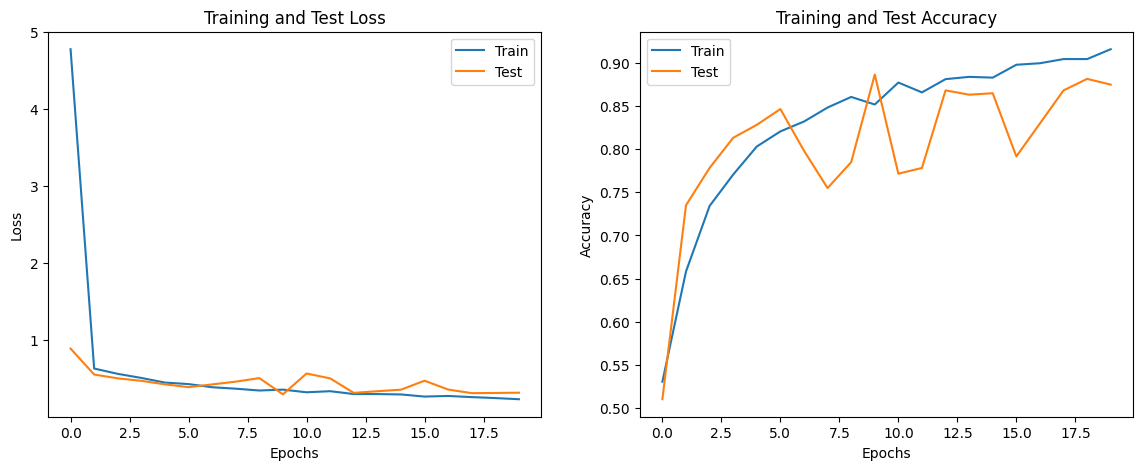

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, input_channels, classes=10, **kwargs):
        super(AlexNet, self).__init__(**kwargs)

        # Entrada -> 227 x 227 x 3
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 27 x 27 x 96
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 13 x 13 x 256
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        ) # 13 x 13 x 384
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
        ) # 13 x 13 x 384
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        ) # 6 x 6 x 256
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

num_epochs, lr, batch_size, wd_lambda = 20, 0.001, 100, 0.0001

model = AlexNet(input_channels=3, classes=2)
model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd_lambda)

# carregamento do dado
resize_size = 227
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=resize_size)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Usando a ResNet18 Pré Treinada

training on cuda
epoch 1, train loss 0.5139, train acc 0.734, test loss 0.3616, test acc 0.843, time 10.6 sec
epoch 2, train loss 0.3423, train acc 0.854, test loss 0.2995, test acc 0.875, time 10.4 sec
epoch 3, train loss 0.2506, train acc 0.903, test loss 0.3018, test acc 0.877, time 10.5 sec
epoch 4, train loss 0.1788, train acc 0.941, test loss 0.2879, test acc 0.885, time 10.4 sec
epoch 5, train loss 0.1358, train acc 0.957, test loss 0.2780, test acc 0.880, time 10.7 sec
epoch 6, train loss 0.0923, train acc 0.979, test loss 0.2974, test acc 0.887, time 10.4 sec
epoch 7, train loss 0.0667, train acc 0.990, test loss 0.2861, test acc 0.885, time 10.6 sec
epoch 8, train loss 0.0483, train acc 0.993, test loss 0.2986, test acc 0.890, time 10.1 sec
epoch 9, train loss 0.0333, train acc 0.997, test loss 0.3032, test acc 0.887, time 10.6 sec
epoch 10, train loss 0.0285, train acc 0.999, test loss 0.3084, test acc 0.890, time 10.7 sec
epoch 11, train loss 0.0197, train acc 0.999, test l

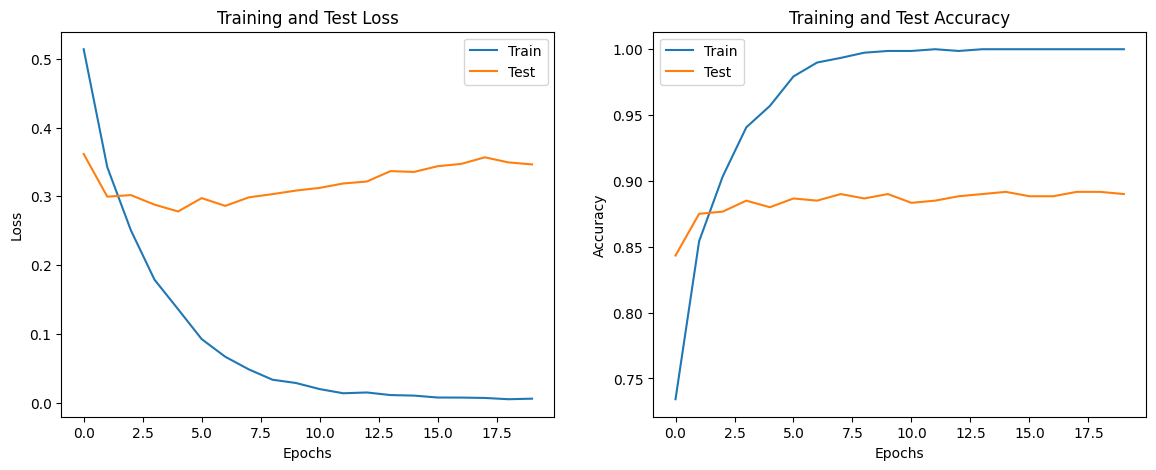

In [ ]:
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# carregamento do dado
resize_size = 224
train_iter, test_iter = load_data(CoffeeDataset, 'brazilian_coffee_scenes', batch_size, resize=resize_size)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

### **Conclusões**

O segundo dataset avaliado foi o Brazilian Coffee Scenes, contendo imagens de sensoriamento remoto de plantações de café com dimensões de 64x64 pixels, e o objetivo era classificar as imagens em duas classes: café e não-café. Novamente, três abordagens distintas foram utilizadas: uma CNN criada do zero, a AlexNet e a ResNet18 pré-treinada.

**CNN Criada do Zero**

A CNN criada do zero apresentou resultados satisfatórios, alcançando uma acurácia de treino de 0.808 e uma acurácia de teste de 0.845. O comportamento do treinamento foi razoavelmente estável, com a loss diminuindo de forma consistente. Isso sugere que a rede foi capaz de capturar as características relevantes do dataset e possivelmente poderia obter resultados ainda melhores com mais épocas de treinamento. A performance estável e a falta de overfitting indicam que esta CNN pode ser uma boa opção para este dataset.

**AlexNet**

A AlexNet também apresentou uma acurácia satisfatória, atingindo 0.916 no conjunto de treino e 0.875 no conjunto de teste. No entanto, similar ao que foi observado no primeiro dataset, o treinamento foi marcado por instabilidades devido ao uso do otimizador Adam. As variações na loss e na acurácia durante o treinamento sugerem que o Adam pode não ser o otimizador mais adequado para este cenário específico. Neste caso, a CNN criada do zero apresentou um desempenho mais estável, e um teste com um otimizador diferente poderia potencialmente melhorar a estabilidade e a performance da AlexNet.

**ResNet18 Pré-treinada**

A ResNet18 pré-treinada apresentou um comportamento interessante, alcançando uma acurácia de treino de 100%, enquanto a acurácia de teste ficou em 0.890. Observando o gráfico de treinamento, nota-se que a loss de treino continuou diminuindo consistentemente, enquanto a loss do conjunto de teste começou a aumentar a partir da quinta época, indicando um claro sinal de overfitting. Este comportamento pode ser atribuído à simplicidade dos dados, dado que as imagens têm apenas 64x64 pixels. Isso sugere que uma rede tão complexa como a ResNet18 pode não ser necessária para este dataset.

A CNN criada do zero entregou resultados satisfatórios sem sinais de overfitting, sugerindo que para este caso específico, uma rede mais simples pode ser mais eficaz. Com alguns ajustes no treinamento ou nas técnicas de augmentação de dados, poderia-se alcançar um resultado ainda melhor.

## Problema 3

Neste problema, classificaremos imagens gerais de sensoriamento remoto do dataset público [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html).
Neste caso, vamos receber imagens de $256\times 256$ pixels e classificá-las entre 21 classes:

1. agricultural
1. airplane
1. baseballdiamond
1. beach
1. buildings
1. chaparral
1. denseresidential
1. forest
1. freeway
1. golfcourse
1. harbor
1. intersection
1. mediumresidential
1. mobilehomepark
1. overpass
1. parkinglot
1. river
1. runway
1. sparseresidential
1. storagetanks
1. tenniscourt

In [ ]:
# Baixando o dataset
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip

--2024-06-28 16:40:14--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.1’

UCMerced_LandUse.zi 100%[===================>] 317.07M  29.8MB/s    in 11s     

2024-06-28 16:40:25 (29.8 MB/s) - ‘UCMerced_LandUse.zip.1’ saved [332468434/332468434]

replace UCMerced_LandUse/Images/agricultural/agricultural00.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
y


### Visualizando o dataset

Number of images in class harbor: 100
Number of images in class river: 100
Number of images in class golfcourse: 100
Number of images in class parkinglot: 100
Number of images in class freeway: 100
Number of images in class mobilehomepark: 100
Number of images in class beach: 100
Number of images in class agricultural: 100
Number of images in class denseresidential: 100
Number of images in class buildings: 100
Number of images in class forest: 100
Number of images in class overpass: 100
Number of images in class airplane: 100
Number of images in class tenniscourt: 100
Number of images in class sparseresidential: 100
Number of images in class mediumresidential: 100
Number of images in class runway: 100
Number of images in class chaparral: 100
Number of images in class storagetanks: 100
Number of images in class baseballdiamond: 100
Number of images in class intersection: 100
Total number of images: 2100


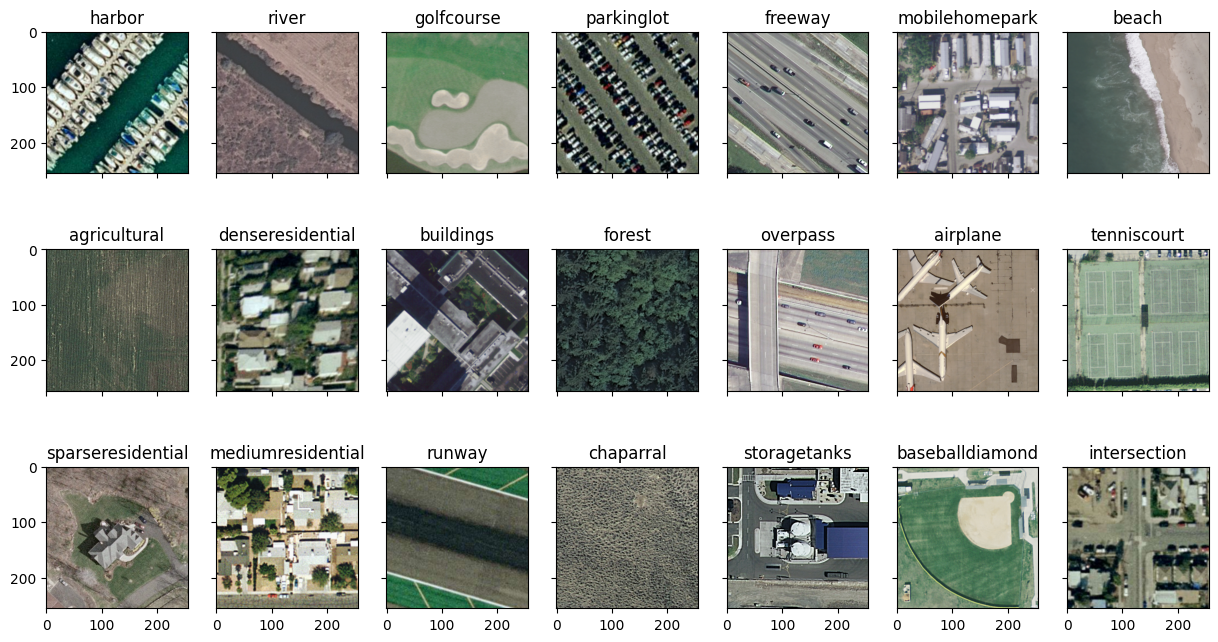

In [ ]:
import random

rows = 3
columns = 7

fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(15, 8))

path = 'UCMerced_LandUse/Images'
total_num_images = 0
for idx, folder in enumerate(os.listdir(path)):
  folder_path = os.path.join(path, folder)
  num_images = len(os.listdir(folder_path))
  total_num_images += num_images
  print(f"Number of images in class {folder}: {num_images}")

  img_name = random.sample(os.listdir(folder_path), 1)[0]
  img = np.asarray(Image.open(os.path.join(folder_path, img_name)))

  ax = axs[idx//columns][idx%columns]
  ax.set_title(folder)
  ax.imshow(img)

print(f"Total number of images: {total_num_images}")

### Dataloader

Imagens de satélite apresentam características que tornam certas transformações particularmente benéficas para redes neurais. Flips, rotações e crops são especialmente eficazes, pois aumentam a robustez do modelo e refletem as variações comuns nas imagens de satélite. Essas transformações ajudam a rede a generalizar melhor, capturando a diversidade e complexidade dos dados de satélite.

In [ ]:
class UCMercedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # IMPLEMENTE AQUI A LEITURA DAS IMAGENS

        # para este dataset, as imagens estão dividas em pastas com o nome da classe
        # uma sugestão é usar o enumerate do Python para percorrer essas pastas, atribuindo o valor do enumerate como label da classe
        # outra opção é definir um dicionário com o label de cada classe como no exemplo do Colerectal histology
        # para cada pasta, selecione as primeiras 80 imagens para o treino e o restante para o teste
        img_list, labels = [], []

        if self.train is True:
          for label, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
              if num < 80:
                img_list.append(os.path.join(self.root, folder, img_name))
                labels.append(label)
        else:
          for label, folder in enumerate(os.listdir(self.root)):
            for num, img_name in enumerate(os.listdir(os.path.join(self.root, folder))):
              if num >= 80:
                img_list.append(os.path.join(self.root, folder, img_name))
                labels.append(label)

        return img_list, labels

    def __getitem__(self, item):
        # IMPLEMENTE AQUI O RETORNO E TRATAMENTO DE CADA IMAGEM

        # lembre-se de aplicar as transformações enviadas ao dataloader (principalmente o ToTensor)

        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            img = self.transform(Image.open(self.img_list[item]))
        label = self.labels[item]
        return img, label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # IMPLEMENTE AQUI A DEFINIÇÃO DAS TRANSFORMAÇÕES E DO DATALOADER

    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # a principal para o nosso caso é o ToTensor, que converte a imagem no formato lido para um tensor
    # experimente transformações diferentes, como crops e flips
    # o resize pode ser necessário para datasets com imagems de tamanhos variados

    # defina também o dataloader de treino e teste

    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer.extend([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.RandomResizedCrop(resize, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
    ])
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação
    num_workers = 0 #if sys.platform.startswith('win32') else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste

    return train_iter, test_iter

# carregamento do dado
batch_size = 64
train_iter, test_iter = load_data(UCMercedDataset, os.path.join('UCMerced_LandUse', 'Images'), batch_size, resize=256)

### Implementação das Redes

#### CNN criada do zero

training on cuda
epoch 1, train loss 3.0366, train acc 0.058, test loss 2.9995, test acc 0.126, time 22.0 sec
epoch 2, train loss 2.9628, train acc 0.107, test loss 2.9335, test acc 0.138, time 17.6 sec
epoch 3, train loss 2.8598, train acc 0.124, test loss 2.8669, test acc 0.198, time 17.1 sec
epoch 4, train loss 2.8171, train acc 0.142, test loss 2.8326, test acc 0.217, time 16.9 sec
epoch 5, train loss 2.7337, train acc 0.177, test loss 2.7564, test acc 0.243, time 17.3 sec
epoch 6, train loss 2.6940, train acc 0.185, test loss 2.6995, test acc 0.219, time 18.2 sec
epoch 7, train loss 2.6060, train acc 0.213, test loss 2.6037, test acc 0.274, time 17.4 sec
epoch 8, train loss 2.5550, train acc 0.218, test loss 2.5217, test acc 0.264, time 17.3 sec
epoch 9, train loss 2.4354, train acc 0.240, test loss 2.4530, test acc 0.288, time 17.4 sec
epoch 10, train loss 2.4172, train acc 0.257, test loss 2.4018, test acc 0.302, time 17.2 sec
epoch 11, train loss 2.3655, train acc 0.258, test l

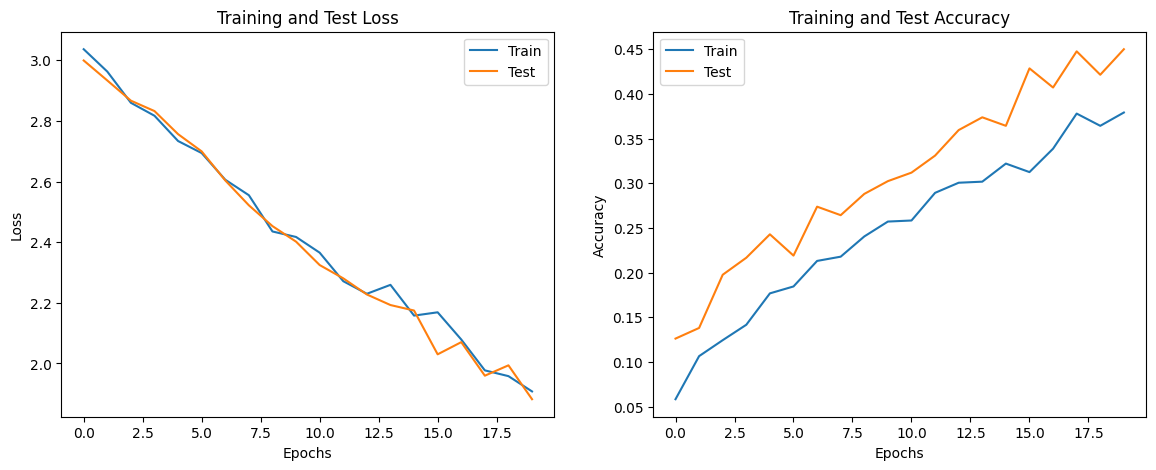

In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(MyCNNModel, self).__init__()
        # Primeira camada -> Input=3x256x256 | Output=64x128x128
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Segunda camada -> Input=64x128x128 | Output=128x64x64
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.3)

        # Terceira camada -> Input=128x64x64 | Output=256x32x32
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.3)

        # Fully connected -> Input=256x32x32
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(256 * 32 * 32, 512)
        self.act4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.5)

        # Camada de saída
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.drop4(x)

        x = self.fc2(x)
        return x

# Parâmetros de treinamento
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

# Instanciar e mover o modelo para o dispositivo
model = MyCNNModel(num_classes=21)
model.to(device)

# Definir função de perda e otimizador
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
data_root = os.path.join('UCMerced_LandUse', 'Images')
train_loader, test_loader = load_data(UCMercedDataset, data_root, batch_size, resize=256)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Replicando a VGG

training on cuda


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.50 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.50 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,


epoch 1, train loss 2.9870, train acc 0.065, test loss 3.0431, test acc 0.057, time 46.1 sec
epoch 2, train loss 2.7532, train acc 0.177, test loss 2.5689, test acc 0.238, time 46.1 sec
epoch 3, train loss 2.3860, train acc 0.271, test loss 2.0586, test acc 0.336, time 46.0 sec
epoch 4, train loss 1.9673, train acc 0.358, test loss 1.8238, test acc 0.393, time 45.7 sec
epoch 5, train loss 1.7259, train acc 0.435, test loss 1.5904, test acc 0.467, time 46.1 sec
epoch 6, train loss 1.4672, train acc 0.514, test loss 1.5081, test acc 0.490, time 46.0 sec
epoch 7, train loss 1.3703, train acc 0.545, test loss 1.2306, test acc 0.590, time 46.0 sec
epoch 8, train loss 1.2530, train acc 0.575, test loss 1.1423, test acc 0.588, time 46.3 sec
epoch 9, train loss 1.0767, train acc 0.646, test loss 1.1588, test acc 0.650, time 46.3 sec
epoch 10, train loss 1.0261, train acc 0.654, test loss 1.3351, test acc 0.593, time 46.0 sec
epoch 11, train loss 0.9464, train acc 0.690, test loss 0.9586, test 

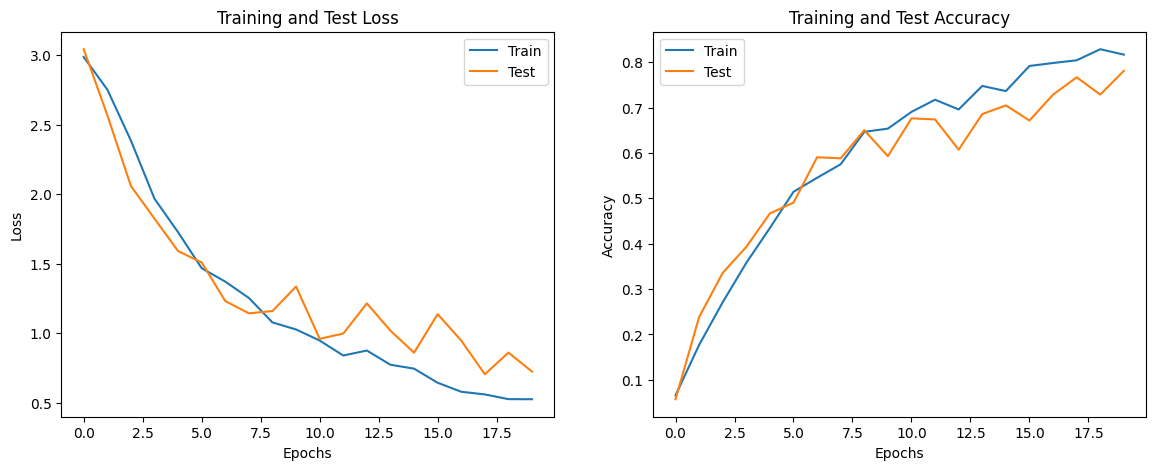

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # Output: 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 64x128x128
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output: 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),# Output: 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 128x64x64
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 256x32x32
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 512x16x16
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 512x8x8
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8 * 8 * 512, 4096),                           # Input: 512x8x8, Output: 4096
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),                                  # Output: 4096
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))                           # Output: num_classes

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Parâmetros de treinamento
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

# Instanciar e mover o modelo para o dispositivo
model = VGG16(num_classes=21)
model.to(device)

# Definir função de perda e otimizador
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
data_root = os.path.join('UCMerced_LandUse', 'Images')
train_loader, test_loader = load_data(UCMercedDataset, data_root, batch_size, resize=256)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Usando a ResNet18 Pré Treinada

training on cuda
epoch 1, train loss 2.7941, train acc 0.206, test loss 2.2121, test acc 0.476, time 16.1 sec
epoch 2, train loss 1.7318, train acc 0.648, test loss 1.3204, test acc 0.793, time 15.1 sec
epoch 3, train loss 1.0610, train acc 0.830, test loss 0.8108, test acc 0.879, time 14.2 sec
epoch 4, train loss 0.6668, train acc 0.902, test loss 0.5540, test acc 0.910, time 14.2 sec
epoch 5, train loss 0.4937, train acc 0.921, test loss 0.4255, test acc 0.924, time 14.2 sec
epoch 6, train loss 0.3724, train acc 0.949, test loss 0.3365, test acc 0.950, time 14.2 sec
epoch 7, train loss 0.3082, train acc 0.954, test loss 0.2545, test acc 0.967, time 15.7 sec
epoch 8, train loss 0.2449, train acc 0.961, test loss 0.2488, test acc 0.952, time 14.6 sec
epoch 9, train loss 0.2132, train acc 0.968, test loss 0.2095, test acc 0.957, time 14.3 sec
epoch 10, train loss 0.1838, train acc 0.977, test loss 0.1925, test acc 0.967, time 14.3 sec
epoch 11, train loss 0.1834, train acc 0.972, test l

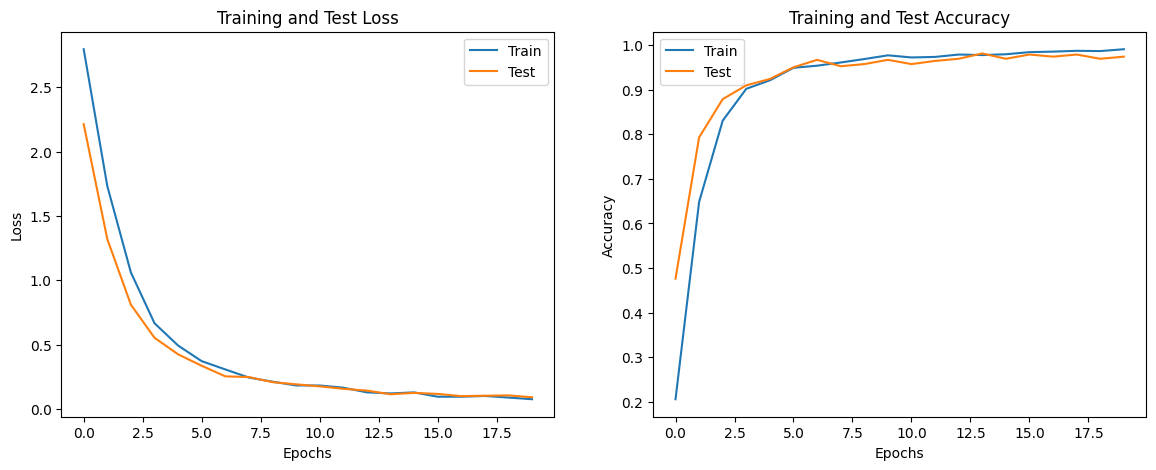

In [ ]:
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 21)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
data_root = os.path.join('UCMerced_LandUse', 'Images')
train_loader, test_loader = load_data(UCMercedDataset, data_root, batch_size, resize=256)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

### **Conclusões**

O terceiro dataset trabalhado foi o UCMerced, contendo imagens de sensoriamento remoto com dimensões de 256x256 pixels, e o objetivo era classificá-las entre 21 classes diferentes. Dado o caráter de sensoriamento remoto do dataset, foram aplicadas diversas técnicas de augmentação para aumentar a robustez do modelo, considerando que tais imagens podem aparecer em diferentes orientações ou posições no grid.

**Criada do Zero**

A CNN criada do zero apresentou resultados insatisfatórios, alcançando uma acurácia de treino de 0.379 e uma acurácia de teste de 0.450. Embora o treinamento tenha sido estável, os resultados indicam que a rede não conseguiu aprender adequadamente as características do dataset. A baixa acurácia sugere que seriam necessárias mais épocas de treinamento ou um volume maior de dados para alcançar resultados mais razoáveis.

**VGG**

A VGG apresentou uma melhoria significativa em relação à CNN do zero, alcançando uma acurácia de treino de 0.817 e uma acurácia de teste de 0.781. A VGG conseguiu entender melhor os dados e representá-los de forma mais eficaz, entregando resultados satisfatórios mesmo com um volume limitado de dados. Este desempenho sugere que a VGG é uma opção mais robusta para este dataset. Com um número maior de épocas de treinamento ou um volume maior de dados, espera-se que a VGG pudesse resolver o problema de classificação de forma ainda mais eficaz.

**ResNet18 Pré-treinada**

A ResNet18 pré-treinada foi, definitivamente, a abordagem que alcançou os melhores resultados, atingindo uma acurácia de treino de 0.990 e uma acurácia de teste de 0.974. Não houve indícios de overfitting, pois as losses de treino e teste diminuíram de forma consistente e as acurácias de treino e teste permaneceram próximas. Este desempenho superior pode ser atribuído ao fato de a ResNet18 ser uma rede pré-treinada em um grande volume de dados, permitindo que os conhecimentos adquiridos sejam transferidos para a nova tarefa.

## Problema 4

Neste problema, classificaremos imagens genéricas de textura do dataset público [*Describable Textures Dataset*](http://www.robots.ox.ac.uk/~vgg/data/dtd/).
Neste caso, vamos receber imagens com tamanho variado (de $300\times 300$ pixels até $640\times 640$) e classificá-las entre 47 classes:

1.  banded
1.  blotchy
1.  braided
1.  bubbly
1.  bumpy
1.  chequered
1.  cobwebbed
1.  cracked
1.  crosshatched
1.  crystalline
1.  dotted
1.  fibrous
1.  flecked
1.  freckled
1.  frilly
1.  gauzy
1.  grid
1.  grooved
1.  honeycombed
1.  interlaced
1.  knitted
1.  lacelike
1.  lined
1.  marbled
1.  matted
1.  meshed
1.  paisley
1.  perforated
1.  pitted
1.  pleated
1.  polka-dotted
1.  porous
1.  potholed
1.  scaly
1.  smeared
1.  spiralled
1.  sprinkled
1.  stained
1.  stratified
1.  striped
1.  studded
1.  swirly
1.  veined
1.  waffled
1.  woven
1.  wrinkled
1.  zigzagged

In [3]:
# Download do dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xzf dtd-r1.0.1.tar.gz

--2024-06-29 18:40:37--  http://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz [following]
--2024-06-29 18:40:37--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz [following]
--2024-06-29 18:40:37--  https://thor.robots.ox.ac.uk/datasets/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting res

### Visualizando o Dataset

Number of images in class striped: 120
Number of images in class freckled: 120
Number of images in class sprinkled: 120
Number of images in class dotted: 120
Number of images in class grooved: 120
Number of images in class blotchy: 120
Number of images in class veined: 120
Number of images in class perforated: 120
Number of images in class crosshatched: 120
Number of images in class lacelike: 120
Number of images in class potholed: 120
Number of images in class smeared: 120
Number of images in class flecked: 120
Number of images in class cracked: 120
Number of images in class scaly: 120
Number of images in class studded: 120
Number of images in class crystalline: 120
Number of images in class meshed: 120
Number of images in class frilly: 120
Number of images in class chequered: 120
Number of images in class marbled: 120
Number of images in class interlaced: 120
Number of images in class fibrous: 120
Number of images in class spiralled: 120
Number of images in class stratified: 120
Numb

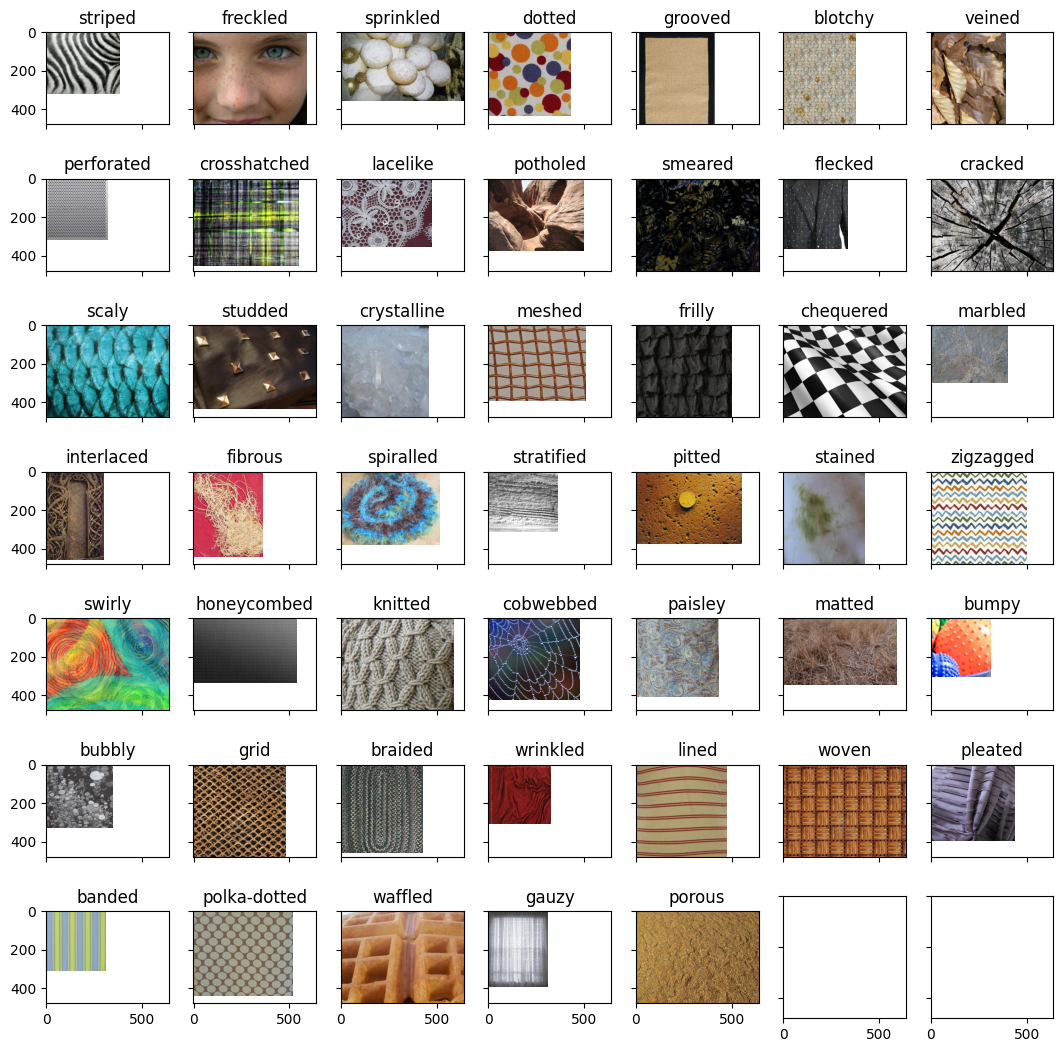

In [4]:
import random

rows = 7
columns = 7

fig, axs = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(13, 13))

path = 'dtd/images'
total_num_images = 0
for idx, folder in enumerate(os.listdir(path)):
  folder_path = os.path.join(path, folder)
  num_images = len(os.listdir(folder_path))
  total_num_images += num_images
  print(f"Number of images in class {folder}: {num_images}")

  img_name = random.sample(os.listdir(folder_path), 1)[0]
  img = np.asarray(Image.open(os.path.join(folder_path, img_name)))

  ax = axs[idx//columns][idx%columns]
  ax.set_title(folder)
  ax.imshow(img)

print(f"Total number of images: {total_num_images}")

### DataLoader

In [5]:
class TextureDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform, train=False, calc_norm=False, has_norm=True):
        self.root = root
        self.train = train
        self.calc_norm = calc_norm
        self.has_norm = has_norm
        self.le = {'banded': 0, 'blotchy': 1, 'braided': 2, 'bubbly': 3, 'bumpy': 4,
                   'chequered': 5, 'cobwebbed': 6, 'cracked': 7, 'crosshatched': 8,
                   'crystalline': 9, 'dotted': 10, 'fibrous': 11, 'flecked': 12,
                   'freckled': 13, 'frilly': 14, 'gauzy': 15, 'grid': 16, 'grooved': 17,
                   'honeycombed': 18, 'interlaced': 19, 'knitted': 20, 'lacelike': 21, 'lined': 22,
                   'marbled': 23, 'matted': 24, 'meshed': 25, 'paisley': 26, 'perforated': 27,
                   'pitted': 28, 'pleated': 29, 'polka-dotted': 30, 'porous': 31, 'potholed': 32,
                   'scaly': 33, 'smeared': 34, 'spiralled': 35, 'sprinkled': 36, 'stained': 37,
                   'stratified': 38, 'striped': 39, 'studded': 40, 'swirly': 41, 'veined': 42,
                   'waffled': 43, 'woven': 44, 'wrinkled': 45, 'zigzagged': 46} # dicionário definindo o label de cada classe
        self.transform = transform
        self.load_images()

    def load_images(self):
        self.img_list, self.labels = self.read_images(root=self.root)

    def read_images(self, root):
        # IMPLEMENTE AQUI A LEITURA DAS IMAGENS

        # para este caso, na pasta images estão as imagens separadas por pastas relacionadas a classe
        # na pasta label existem txts definindo a divisão das imagens em treino, teste e validação
        # utilize as imagens nos arquivos train1.txt e val1.txt como treino
        # utilize as imagens nos arquivos teste1.txt como validação
        # lembre-se de atribuir o label de acordo com o dicionário self.le definido acima

        img_list, labels = [], []

        file_path = os.path.join(self.root, 'labels', 'train1.txt' if self.train else 'val1.txt')

        with open(file_path) as file:
          for line in file:
            img_list.append(os.path.join(self.root, 'images', line.strip()))
            label = line.split('/')[0]
            labels.append(self.le[label])

        return img_list, labels

    def __getitem__(self, item):
        # IMPLEMENTE AQUI O RETORNO E TRATAMENTO DE CADA IMAGEM

        # lembre-se de aplicar as transformações enviadas ao dataloader (principalmente o ToTensor)
        # retorna uma imagem para o treino/teste
        if self.has_norm is True:
            # normaliza a imagem se has_norm for setado como True
            img = self.normalize_image(self.transform(Image.open(self.img_list[item])))
        else:
            # apenas converte a imagem para tensor, sem normalizar
            img = self.transform(Image.open(self.img_list[item]))
        label = self.labels[item]
        return img, label

    def __len__(self):
        return len(self.img_list)

    def normalize_image(self, img):
        # normaliza uma imagem
        # se calc_norm for True, normaliza pela subtração da média dividida pelo desvio para cada canal da imagem
        # se calc_norm for False, normaliza pelos valores pré-definidos de média e desvio padrão
        if self.calc_norm is True:
            for i in range(img.shape[0]):
                mu = img[i, :, :].mean()
                std = img[i, :, :].std()
                img[i, :, :] = ((img[i, :, :] - mu) / std)
        else:
            img = torchvision.transforms.functional.normalize(img,
                                                mean=torch.Tensor([0.485, 0.456, 0.406]),
                                                std=torch.Tensor([0.229, 0.224, 0.225]))
        return img


def load_data(dataset, root, batch_size, resize=None):
    # IMPLEMENTE AQUI A DEFINIÇÃO DAS TRANSFORMAÇÕES E DO DATALOADER

    # o transformer define a sequência de transformações que serão aplicadas na imagem
    # a principal para o nosso caso é o ToTensor, que converte a imagem no formato lido para um tensor
    # experimente transformações diferentes, como crops e flips
    # o resize pode ser necessário para datasets com imagems de tamanhos variados

    # defina também o dataloader de treino e teste

    transformer = []
    if resize is not None:
        transformer += [torchvision.transforms.Resize(size=(resize,resize))]
    transformer.extend([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.RandomResizedCrop(resize, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
    ])
    transformer = torchvision.transforms.Compose(transformer)

    train = dataset(root=root, transform=transformer, train=True) #obtem dataset de treino
    test = dataset(root=root, transform=transformer, train=False) #obtem dataset de validação

    num_workers = 0 if os.name == 'nt' else 4

    train_iter = torch.utils.data.DataLoader(train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers) # criação do dataloader de treino
    test_iter = torch.utils.data.DataLoader(test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers) # criação do dataloader de teste

    return train_iter, test_iter

# carregamento do dado
batch_size = 32
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=640) # Sempre redimensiona para o tamanho da maior imagem

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Implementação dos Modelos

#### CNN criada do zero

training on cuda
epoch 1, train loss 3.8569, train acc 0.020, test loss 3.8472, test acc 0.021, time 103.8 sec
epoch 2, train loss 3.8504, train acc 0.020, test loss 3.8455, test acc 0.024, time 99.8 sec
epoch 3, train loss 3.8482, train acc 0.020, test loss 3.8442, test acc 0.031, time 99.8 sec
epoch 4, train loss 3.8454, train acc 0.021, test loss 3.8431, test acc 0.028, time 105.5 sec
epoch 5, train loss 3.8460, train acc 0.026, test loss 3.8423, test acc 0.031, time 108.3 sec
epoch 6, train loss 3.8431, train acc 0.026, test loss 3.8421, test acc 0.029, time 104.2 sec
epoch 7, train loss 3.8393, train acc 0.026, test loss 3.8405, test acc 0.030, time 93.9 sec
epoch 8, train loss 3.8351, train acc 0.026, test loss 3.8392, test acc 0.030, time 94.4 sec
epoch 9, train loss 3.8328, train acc 0.030, test loss 3.8373, test acc 0.028, time 97.8 sec
epoch 10, train loss 3.8295, train acc 0.033, test loss 3.8340, test acc 0.029, time 104.7 sec
epoch 11, train loss 3.8268, train acc 0.029, t

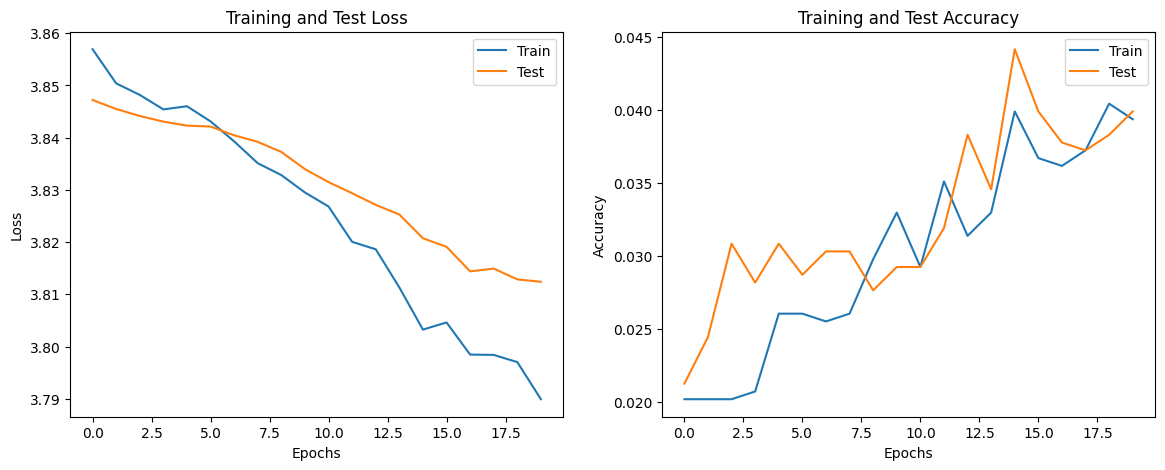

In [6]:
class MyCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(MyCNNModel, self).__init__()
        # Primeira camada -> Input=3x640x640 | Output=64x107x107
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop1 = nn.Dropout(0.3)

        # Segunda camada -> Input=64x107x107 | Output=128x27x27
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop2 = nn.Dropout(0.3)

        # Terceira camada -> Input=128x27x27 | Output=256x13x13
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop3 = nn.Dropout(0.3)

        # Quarta camada -> Input=256x13x13 | Output=512x6x6
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop4 = nn.Dropout(0.3)

        # Fully connected -> Input=512x6x6
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(512 * 6 * 6, 256)
        self.act5 = nn.ReLU()
        self.drop5 = nn.Dropout(0.5)

        # Camada de saída
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.act3(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.act4(self.conv4(x))
        x = self.pool4(x)
        x = self.drop4(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.act5(x)
        x = self.drop5(x)

        x = self.fc2(x)
        return x

# Parâmetros de treinamento
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

# Instanciar e mover o modelo para o dispositivo
model = MyCNNModel(num_classes=47)
model.to(device)

# Definir função de perda e otimizador
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=640)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Replicando a VGG

training on cuda
epoch 1, train loss 3.8680, train acc 0.023, test loss 3.8135, test acc 0.037, time 58.2 sec
epoch 2, train loss 3.8197, train acc 0.036, test loss 3.7460, test acc 0.055, time 57.8 sec
epoch 3, train loss 3.7320, train acc 0.056, test loss 3.6841, test acc 0.076, time 57.3 sec
epoch 4, train loss 3.6254, train acc 0.079, test loss 3.6008, test acc 0.079, time 58.6 sec
epoch 5, train loss 3.5550, train acc 0.093, test loss 3.5822, test acc 0.112, time 57.0 sec
epoch 6, train loss 3.4538, train acc 0.109, test loss 3.5066, test acc 0.108, time 58.6 sec
epoch 7, train loss 3.3962, train acc 0.124, test loss 3.4925, test acc 0.119, time 57.2 sec
epoch 8, train loss 3.3592, train acc 0.130, test loss 3.5280, test acc 0.115, time 58.6 sec
epoch 9, train loss 3.3095, train acc 0.143, test loss 3.4686, test acc 0.123, time 56.7 sec
epoch 10, train loss 3.2950, train acc 0.137, test loss 3.5154, test acc 0.116, time 57.1 sec
epoch 11, train loss 3.2607, train acc 0.151, test l

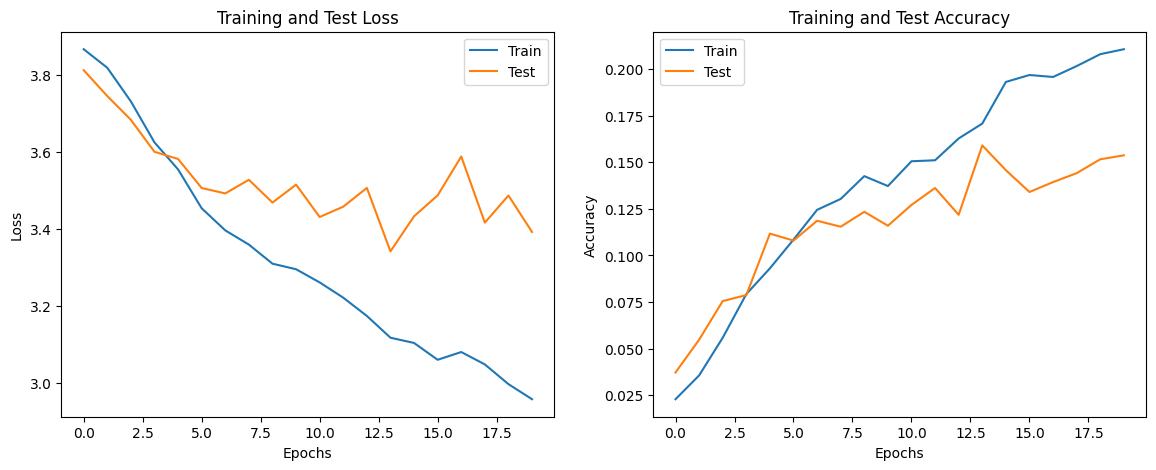

In [7]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Output: 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), # Output: 64x256x256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 64x128x128
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Output: 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),# Output: 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 128x64x64
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),# Output: 256x64x64
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 256x32x32
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x32x32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 512x16x16
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),# Output: 512x16x16
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))                  # Output: 512x8x8
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8 * 8 * 512, 4096),                           # Input: 512x8x8, Output: 4096
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),                                  # Output: 4096
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))                           # Output: num_classes

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Parâmetros de treinamento
num_epochs, lr, batch_size, momentum = 20, 0.001, 32, 0.9

# Instanciar e mover o modelo para o dispositivo
model = VGG16(num_classes=47)
model.to(device)

# Definir função de perda e otimizador
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=256)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Usando a ResNet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


training on cuda
epoch 1, train loss 3.8733, train acc 0.052, test loss 3.5041, test acc 0.149, time 30.6 sec
epoch 2, train loss 3.1713, train acc 0.289, test loss 2.8831, test acc 0.355, time 29.1 sec
epoch 3, train loss 2.5406, train acc 0.459, test loss 2.4191, test acc 0.440, time 29.2 sec
epoch 4, train loss 2.0753, train acc 0.529, test loss 2.1026, test acc 0.481, time 28.7 sec
epoch 5, train loss 1.7759, train acc 0.587, test loss 1.8853, test acc 0.526, time 29.0 sec
epoch 6, train loss 1.5344, train acc 0.629, test loss 1.7599, test acc 0.521, time 29.9 sec
epoch 7, train loss 1.3717, train acc 0.660, test loss 1.6522, test acc 0.553, time 28.4 sec
epoch 8, train loss 1.2334, train acc 0.699, test loss 1.5967, test acc 0.568, time 28.6 sec
epoch 9, train loss 1.1401, train acc 0.718, test loss 1.5513, test acc 0.574, time 28.8 sec
epoch 10, train loss 1.0620, train acc 0.727, test loss 1.5160, test acc 0.576, time 31.1 sec
epoch 11, train loss 0.9619, train acc 0.747, test l

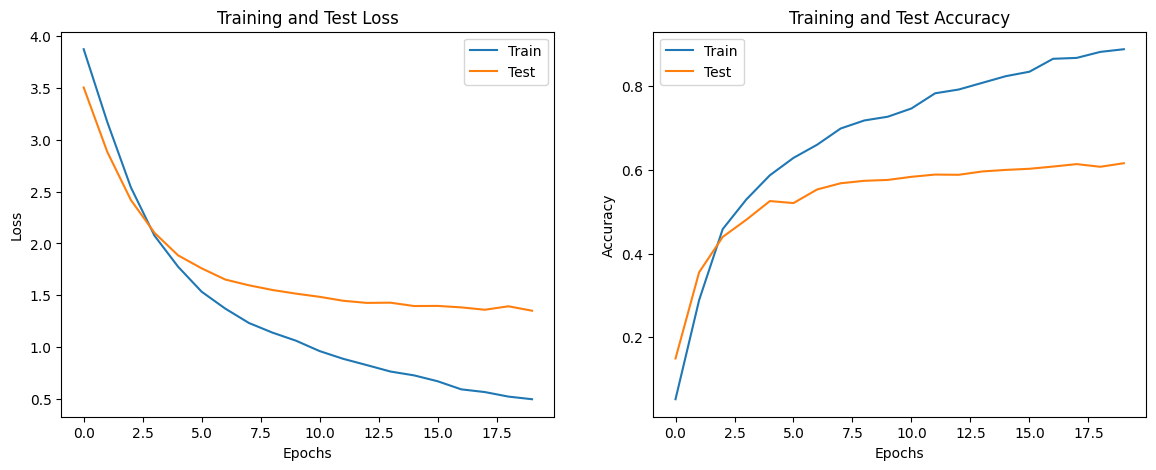

In [8]:
num_epochs, lr, batch_size, momentum = 20, 0.001, 64, 0.9

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 47)

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Carregamento dos dados
train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=256)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

#### Usando a Inception V3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


training on cuda
epoch 1, train loss 5.3211, train acc 0.057, test loss 3.6033, test acc 0.226, time 71.5 sec
epoch 2, train loss 4.7075, train acc 0.237, test loss 3.0944, test acc 0.418, time 75.6 sec
epoch 3, train loss 3.9130, train acc 0.412, test loss 2.4795, test acc 0.483, time 70.1 sec
epoch 4, train loss 3.1698, train acc 0.520, test loss 2.0180, test acc 0.539, time 72.4 sec
epoch 5, train loss 2.6661, train acc 0.553, test loss 1.7517, test acc 0.557, time 70.5 sec
epoch 6, train loss 2.3052, train acc 0.606, test loss 1.5666, test acc 0.586, time 71.4 sec
epoch 7, train loss 2.0137, train acc 0.638, test loss 1.4841, test acc 0.600, time 70.8 sec
epoch 8, train loss 1.7784, train acc 0.685, test loss 1.4388, test acc 0.599, time 71.4 sec
epoch 9, train loss 1.6576, train acc 0.695, test loss 1.4201, test acc 0.603, time 73.6 sec
epoch 10, train loss 1.5069, train acc 0.715, test loss 1.4058, test acc 0.593, time 73.1 sec
epoch 11, train loss 1.3512, train acc 0.747, test l

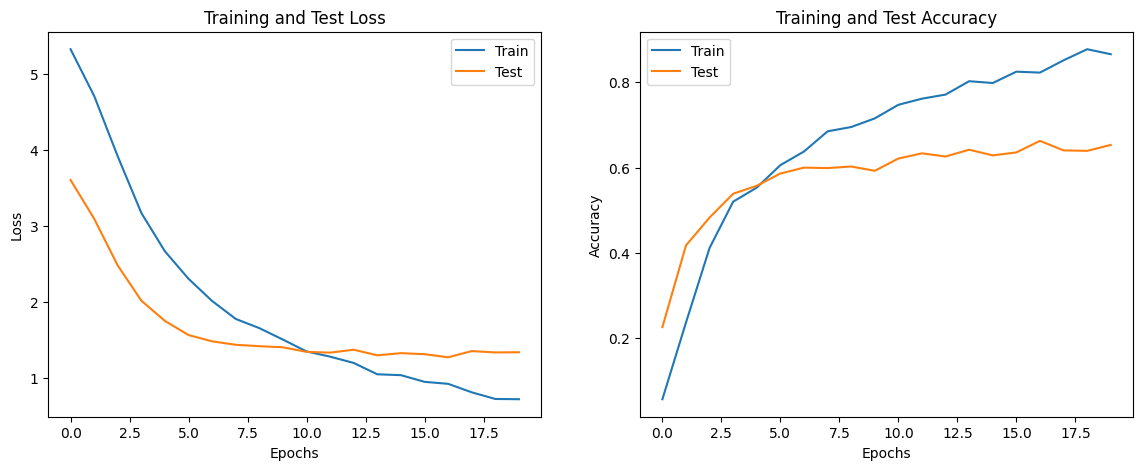

In [ ]:
num_epochs, lr, batch_size, momentum = 20, 0.001, 32, 0.9

model = torchvision.models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 47)

num_ftrs_aux = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs_aux, 47)
model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

train_iter, test_iter = load_data(TextureDataset, os.path.join('dtd'), batch_size, resize=299)

train_validate(model, train_iter, test_iter, batch_size, optimizer, loss, num_epochs)

### **Conclusões**

O último dataset avaliado foi o Describable Textures Dataset (DTD), que contém imagens genéricas de texturas com tamanhos variados, desde 300x300 pixels até 640x640 pixels. O objetivo era classificar essas imagens entre 47 classes diferentes. Quatro abordagens distintas foram utilizadas: uma CNN criada do zero, a VGG, a ResNet18 pré-treinada e a Inception V3.

**CNN Criada do Zero**

Dada a resolução maior das imagens, foi adicionado um stride nas camadas iniciais para diminuir a resolução mais rapidamente, e uma quarta camada convolucional foi adicionada. Mesmo assim, a CNN criada do zero apresentou resultados insatisfatórios, alcançando uma acurácia de treino de 0.039 e uma acurácia de teste de 0.040. O treinamento mostrou que a rede não conseguiu aprender nada sobre os dados, com o erro praticamente não diminuindo ao longo das épocas. Esse desempenho fraco indica que a rede foi incapaz de capturar as características das texturas presentes nas imagens, possivelmente devido à alta dimensionalidade e ao baixo volume de dados disponíveis (5.640 imagens).

**VGG**

A VGG apresentou resultados ligeiramente melhores que a CNN do zero, mas ainda insatisfatórios, com uma acurácia de treino de 0.211 e uma acurácia de teste de 0.154. Esses resultados também indicam que a rede não conseguiu aprender adequadamente sobre os dados. Apesar de sua maior capacidade de modelagem, a VGG ainda não foi eficaz em lidar com a complexidade e a variabilidade do dataset de texturas com um número limitado de imagens.

**ResNet18 Pré-treinada**

A ResNet18 pré-treinada mostrou uma melhoria significativa em relação às redes anteriores, alcançando uma acurácia de treino de 0.888 e uma acurácia de teste de 0.616. Esse desempenho superior evidencia a eficácia das redes pré-treinadas na transferência de conhecimento, especialmente quando se trabalha com datasets pequenos. No entanto, houve um claro sinal de overfitting, com a acurácia de treino sendo muito superior à de teste. A diferença nas losses de treino e teste sugere que a rede aprendeu bem os dados de treino, mas não conseguiu generalizar adequadamente para os dados de teste.

**Inception V3 Pré-treinada**

A Inception V3 apresentou os melhores resultados entre todas as abordagens, alcançando uma acurácia de treino de 0.866 e uma acurácia de teste de 0.653. Apesar do melhor desempenho, a rede também apresentou sinais de overfitting, com a loss de treino significativamente mais baixa do que a loss de teste. Isso sugere que, embora a Inception V3 tenha sido mais eficaz na aprendizagem das texturas, ainda enfrentou dificuldades para generalizar devido ao volume limitado de dados.

**Conclusões Gerais**

O dataset Describable Textures Dataset é complexo devido à alta resolução e variabilidade das imagens, combinado com um volume relativamente baixo de dados (5.640 imagens). As redes neurais criadas do zero e a VGG não conseguiram aprender adequadamente sobre os dados, indicando a necessidade de um volume maior de dados ou de uma maior complexidade nas redes.

Por outro lado, as redes pré-treinadas, como a ResNet18 e a Inception V3, mostraram-se mais eficazes, evidenciando a importância da transferência de aprendizado quando se trabalha com datasets pequenos. No entanto, ambas as redes pré-treinadas apresentaram sinais de overfitting, sugerindo que técnicas adicionais de regularização poderiam ser necessárias para melhorar ainda mais a generalização.